# シミュレーション結果（3D密度グリッド）のプロットデモ

**概要:**
指定されたシミュレーション結果のディレクトリから、
特定のTAA (真近点離角) の.npyファイルを探します。

ファイルを読み込み、3Dの数密度グリッド (atoms/m^3) を
指定された軸方向（視線方向）に積分（合計）し、
2Dの柱密度 (atoms/m^2) を計算します。

結果を matplotlib を使って2Dカラーマップとして表示します。

In [ ]:
# --- セル 2: インポートと設定 ---

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.patches import Circle
import os
import glob  # ファイル検索用

# グラフをノートブック内にインライン表示するためのおまじない
%matplotlib inline

# ==============================================================================
# --- 設定 ---
# ==============================================================================

# 1. シミュレーション結果が保存されているディレクトリ
SIMULATION_RUN_DIRECTORY = r"./Grid101_Range5RM_SP1e+23_PSD"

# 2. プロットしたい TAA (真近点離角)
# 0 ~ 359の値を選択 

# 参考までに、0度では放射圧が弱く、生成率が高いため放射状の広がりが見えます。
# 　　　　　　60度では放射圧が強いため、尾が生成されているのを確認できます。
#            180度では放射圧も、生成率も低いため、薄い大気のみを確認できます。

TARGET_TAA = 60  # 例: 60度のファイルを探す

# 3. シミュレーションで使用したグリッド設定
# (シミュレーションコードの 'GRID_RESOLUTION', 'GRID_MAX_RM' と一致させる)

GRID_RESOLUTION = 101  # グリッド解像度 (例: 101)
GRID_MAX_RM = 5.0  # グリッドの最大範囲 [RM] (例: 5.0)

# 4. 物理定数 (水星半径)
RM_METERS = 2.440e6  # 水星の半径 [m]

# 5. プロット単位
# Trueにすると、天文学で一般的な [atoms/cm^2] でプロットします
PLOT_IN_CM2 = True

# 6. 視点 (どの方向から見るか)
# 'Z': +Z軸方向から (X-Y平面, 'Face-on')
# 'Y': -Y軸方向から (X-Z平面, 'Side-on')
VIEW_FROM = 'Z'

In [2]:
# --- セル 3: 関数定義 ---

def find_simulation_file(directory, taa):
    """
    指定されたTAAに一致する.npyファイルを探します。
    複数のファイルが見つかった場合（例: 1年目と2年目）、
    時系列で最後のファイル（最も新しいファイル）を返します。
    """
    # ファイル名のパターンを作成 (例: density_grid_t*_taa090.npy)
    search_pattern = os.path.join(directory, f"density_grid_*_taa{taa:03d}.npy")

    files = glob.glob(search_pattern)

    if not files:
        print(f"エラー: TAA={taa} に一致するファイルが見つかりません。")
        print(f"検索パス: {search_pattern}")
        return None

    # ファイルを名前でソート（t_secが大きいものが最後に来る）
    files.sort()
    return files[-1]  # 最後のファイル（=最新のシミュレーション結果）を返す


def plot_column_density(density_grid_m3, taa, view_from='Z'):
    """
    3D密度グリッドを指定された軸方向に積分し、2D柱密度マップをプロットします。
    view_from: 'Z' (Z-View) または 'Y' (Y-View)
    """
    print(f"視点 '{view_from}' に基づき、柱密度を計算中...")

    # --- 1. 物理スケールの計算 ---
    # グリッドのセルのサイズ [m]
    grid_min_m = -GRID_MAX_RM * RM_METERS
    grid_max_m = GRID_MAX_RM * RM_METERS
    cell_size_m = (grid_max_m - grid_min_m) / GRID_RESOLUTION

    # --- 2. 柱密度の計算 ---
    if view_from == 'Z':
        # 従来通り: Z軸 (axis=2) に沿って合計する -> X-Y平面
        integration_axis = 2
        xlabel = "X [$R_M$]"
        ylabel = "Y [$R_M$]"
        title_view = "Viewed from +Z (X-Y Plane)"

    elif view_from == 'Y':
        # 新規: Y軸 (axis=1) に沿って合計する -> X-Z平面
        integration_axis = 1
        xlabel = "X [$R_M$]"
        ylabel = "Z [$R_M$]"  # Y軸がZ軸になる
        title_view = "Viewed from -Y (X-Z Plane)"

    else:
        print(f"エラー: 不明な視点 '{view_from}' です。'Z' または 'Y' を指定してください。")
        return

    # 柱密度 N [atoms/m^2] = Σ (数密度 n [atoms/m^3] * セルの厚み [m])
    column_density_m2 = np.sum(density_grid_m3, axis=integration_axis) * cell_size_m

    # --- 3. プロット単位の変換 ---
    if PLOT_IN_CM2:
        # 1 [m^2] = (100 [cm])^2 = 1e4 [cm^2]
        # [atoms/m^2] * (1e-4 [m^2/cm^2]) = [atoms/cm^2]
        column_density_plot = column_density_m2 * 1e-4
        cbar_label = "Column Density [atoms/cm²]"
    else:
        column_density_plot = column_density_m2
        cbar_label = "Column Density [atoms/m²]"

    # --- 4. プロット準備 ---
    plt.style.use('dark_background')

    # プロットの軸範囲 [-5 RM, +5 RM]
    plot_extent = [-GRID_MAX_RM, GRID_MAX_RM, -GRID_MAX_RM, GRID_MAX_RM]

    # ゼロ以下の値はプロットしない（Logスケールのため）
    min_val = np.min(column_density_plot[column_density_plot > 0])
    if not np.isfinite(min_val):
        print("警告: プロットするデータがすべてゼロまたはNaNです。")
        min_val = 1e-1  # とりあえずの値

    print(f"プロットを作成中... (TAA={taa}, View={view_from})")

    fig, ax = plt.subplots(figsize=(10, 8))

    # imshowでプロット
    # origin='lower': (0,0)を左下に
    # extent: 軸の物理単位を設定
    # .T (転置): [ix, iy] 配列を [iy, ix] としてプロットするため、
    #            X軸にix, Y軸にiyが来るように転置する
    #            (Y-Viewの場合 [ix, iz] -> .T -> [iz, ix] となり同様に機能する)
    im = ax.imshow(
        column_density_plot.T,
        origin='lower',
        extent=plot_extent,
        cmap='afmhot',  # 密度プロットに適したカラーマップ
        norm=mcolors.LogNorm(vmin=min_val, vmax=np.max(column_density_plot))  # 対数スケール
    )

    # --- 5. プロットの装飾 ---

    # 水星本体の円を描画
    mercury_circle = Circle((0, 0), 1.0, color='white', fill=False,
                            linestyle='--', linewidth=1, label='Mercury (1 RM)')
    ax.add_patch(mercury_circle)

    # 軸ラベルとタイトル
    ax.set_xlabel(xlabel, fontsize=14)
    ax.set_ylabel(ylabel, fontsize=14)
    
    # この関数が呼ばれる時点で `filepath` はグローバル変数として定義されているため、
    # ここで参照できます。
    ax.set_title(f"Mercury Na Exosphere Column Density ({title_view})\n"
                 f"TAA = {taa}° (File: {os.path.basename(filepath)})",
                 fontsize=12)

    # アスペクト比を1:1に
    ax.set_aspect('equal')

    # カラーバー
    cbar = fig.colorbar(im, ax=ax, pad=0.02)
    cbar.set_label(cbar_label, fontsize=14)

    ax.legend()
    plt.tight_layout()
    
    # .pyスクリプトの plt.show() は、ノートブックでは自動で表示されるため
    # 必須ではありませんが、明示的に書いても問題ありません。
    plt.show()

ファイルが見つかりました:
./Grid101_Range5RM_SP1e+23_PSD\density_grid_t00241_taa060.npy

グリッドデータをロードしました。Shape: (101, 101, 101)
視点 'Z' に基づき、柱密度を計算中...
プロットを作成中... (TAA=60, View=Z)


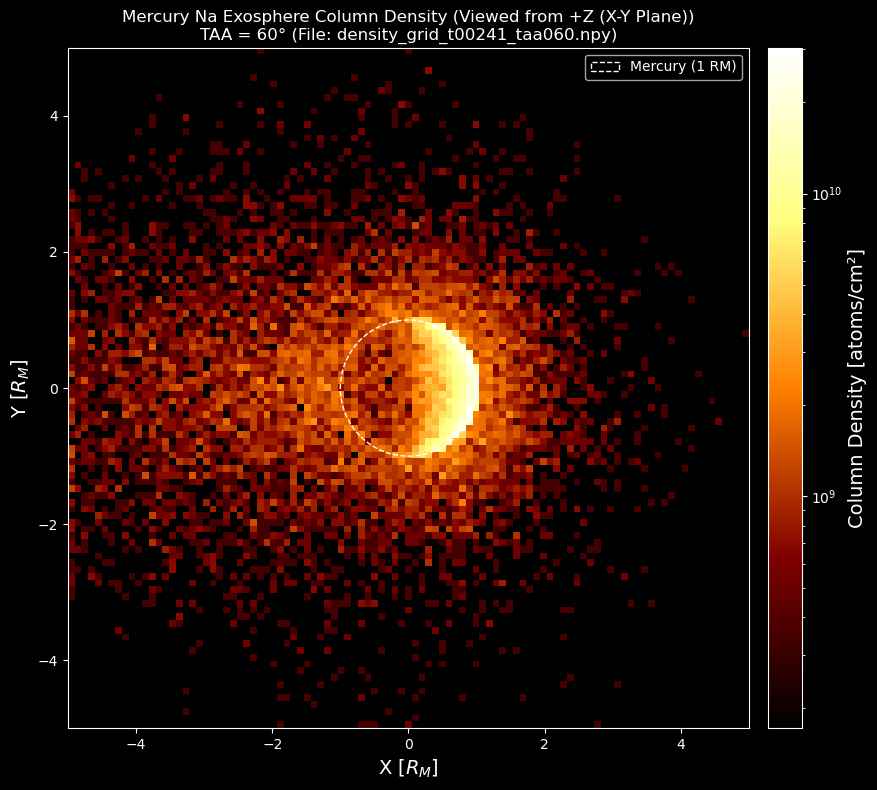

In [3]:
# --- セル 4: メイン実行部 ---
# このセルを実行すると、上記で定義した関数が
# セル2の設定値を使って実行され、
# 結果のグラフがこのセルの直下に表示されます。

# 1. TAAに一致するファイルを探す
# (セル2で定義されたグローバル変数 TARGET_TAA を使用)
filepath = find_simulation_file(SIMULATION_RUN_DIRECTORY, TARGET_TAA)

if filepath:
    print(f"ファイルが見つかりました:\n{filepath}\n")

    # 2. 3D密度グリッドをロード
    try:
        density_grid = np.load(filepath)
        print(f"グリッドデータをロードしました。Shape: {density_grid.shape}")

        # 3. プロット関数を呼び出し
        # (セル3で定義された関数を、セル2で定義された設定値で呼び出す)
        plot_column_density(density_grid, TARGET_TAA, view_from=VIEW_FROM)

    except Exception as e:
        print(f"ファイルのロードまたはプロット中にエラーが発生しました: {e}")

else:
    print(f"デモを終了します。ファイルが見つかりません。")
    print(f"セル2の設定（SIMULATION_RUN_DIRECTORY や TARGET_TAA）を確認してください。")